## Process

Note for the End User: 
The very final Cell of the Ipynb contains the Pipeline to run for the final product.  
The dataset needs to be contained within a folder called "data/".


#### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random as rd
import sklearn.model_selection as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

#### 2. Load Data Files

In [2]:
# test files
test_month_1 = pd.read_csv('data/test_month_1.csv')
test_month_2 = pd.read_csv('data/test_month_2.csv')
test_month_3 = pd.read_csv('data/test_month_3.csv')

# train files
train_month_1 = pd.read_csv('data/train_month_1.csv')
train_month_2 = pd.read_csv('data/train_month_2.csv')
train_month_3_with_target = pd.read_csv('data/train_month_3_with_target.csv')

original = train_month_3_with_target.copy()

In [3]:
np.shape(train_month_3_with_target)


(63697, 40)

#### 3. Clean Variables 

In [4]:
# convert the dates into days before 2018 
train_month_3_with_target["customer_since_all"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_all"])).dt.days
train_month_3_with_target["customer_birth_date"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_birth_date"])).dt.days
train_month_3_with_target["customer_since_bank"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_bank"])).dt.days


In [5]:
# create dummies for the different categorical variables 

train_month_3_with_target = pd.DataFrame(pd.get_dummies(train_month_3_with_target, 
                                   columns = ["customer_education", "customer_occupation_code", "customer_children", "customer_relationship"], 
                                   dummy_na=True))



train_month_3_with_target = train_month_3_with_target.drop(["customer_postal_code"], axis=1)
train_month_3_with_target = train_month_3_with_target.drop(["client_id"], axis=1)

train_month_3_with_target['customer_since_all_na'] = np.where(train_month_3_with_target.customer_since_all.notnull(), '0', '1')
train_month_3_with_target['customer_since_bank_na'] = np.where(train_month_3_with_target.customer_since_bank.notnull(), '0', '1')


In [6]:
# Train Test Split to prevent data pollution
y = train_month_3_with_target['target']
X = train_month_3_with_target.drop(['target'], axis = 1)
X_train, X_val, y_train, y_val = sk.train_test_split(X, y, test_size=0.3, stratify=y)

# create one complete set for testing purposes 
fortest = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)


#### 3. Exploratory Data Analysis

In [7]:
# take a look at missing values
miss_perc = pd.DataFrame()
missings = original[["customer_since_all", "customer_since_bank", "customer_occupation_code", "customer_education", 
                               "customer_children", "customer_relationship", "target"]].copy()

miss_perc["percentage_missing"] = missings.isna().sum(axis=0) / missings.shape[0]

miss_perc["total_missing"] =  missings.isna().sum(axis=0)
miss_perc["missing_on_positive"] = missings.loc[missings["target"] == 1].isna().sum(axis=0)

miss_perc["percentage_positive_missing"] = miss_perc["missing_on_positive"] / miss_perc["total_missing"]

miss_perc["ratio"] = miss_perc["percentage_positive_missing"] / miss_perc["percentage_missing"]

miss_perc = miss_perc[["percentage_missing", "percentage_positive_missing", "ratio"]]

# apparantly the customer_since... variables have comparatively a lot of NAs when our target variable is positive
# We seemingly have almost always very personal information like education, children and relationship about positives
# seems illogical to me => churners are well known?? 

print(round(miss_perc[0:6], 4))


                          percentage_missing  percentage_positive_missing  \
customer_since_all                    0.0037                       0.0513   
customer_since_bank                   0.0039                       0.0562   
customer_occupation_code              0.0314                       0.0385   
customer_education                    0.7398                       0.0190   
customer_children                     0.3668                       0.0288   
customer_relationship                 0.2339                       0.0299   

                            ratio  
customer_since_all        13.9595  
customer_since_bank       14.3830  
customer_occupation_code   1.2237  
customer_education         0.0257  
customer_children          0.0785  
customer_relationship      0.1280  


#### 4. Descriptives 

In [8]:

# distribution of target variable
print(fortest["target"].sum() / fortest.shape[0])

# summary stats of numerical variables 
# only children and relationship are categorical 
fortest.describe()


0.030031175006167716


,homebanking_active,has_homebanking,has_insurance_21,has_insurance_23,has_life_insurance_fixed_cap,has_life_insurance_decreasing_cap,has_fire_car_other_insurance,has_personal_loan,has_mortgage_loan,has_current_account,...,customer_children_no,customer_children_onebaby,customer_children_preschool,customer_children_yes,customer_children_young,customer_children_nan,customer_relationship_couple,customer_relationship_single,customer_relationship_nan,target
count,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.00000,44587.000000,44587.000000,44587.000000,...,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000
mean,0.215668,0.281966,0.095162,0.010205,0.002826,0.112948,0.31646,0.040864,0.098482,0.501491,...,0.359612,0.022832,0.037477,0.005360,0.041806,0.364501,0.570076,0.196761,0.233162,0.030031
std,0.411290,0.449962,0.293442,0.100503,0.053085,0.316532,0.46510,0.197977,0.297968,0.500003,...,0.479892,0.149369,0.189930,0.073018,0.200148,0.481295,0.495070,0.397555,0.422849,0.170675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 5. Modeling

In [9]:
# impute missings in the training data 

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)


In [10]:
# PCA 3D

X = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = ['PCA0', 'PCA1', 'PCA2'])
result = pd.concat([principalDf, y_train], axis = 1)

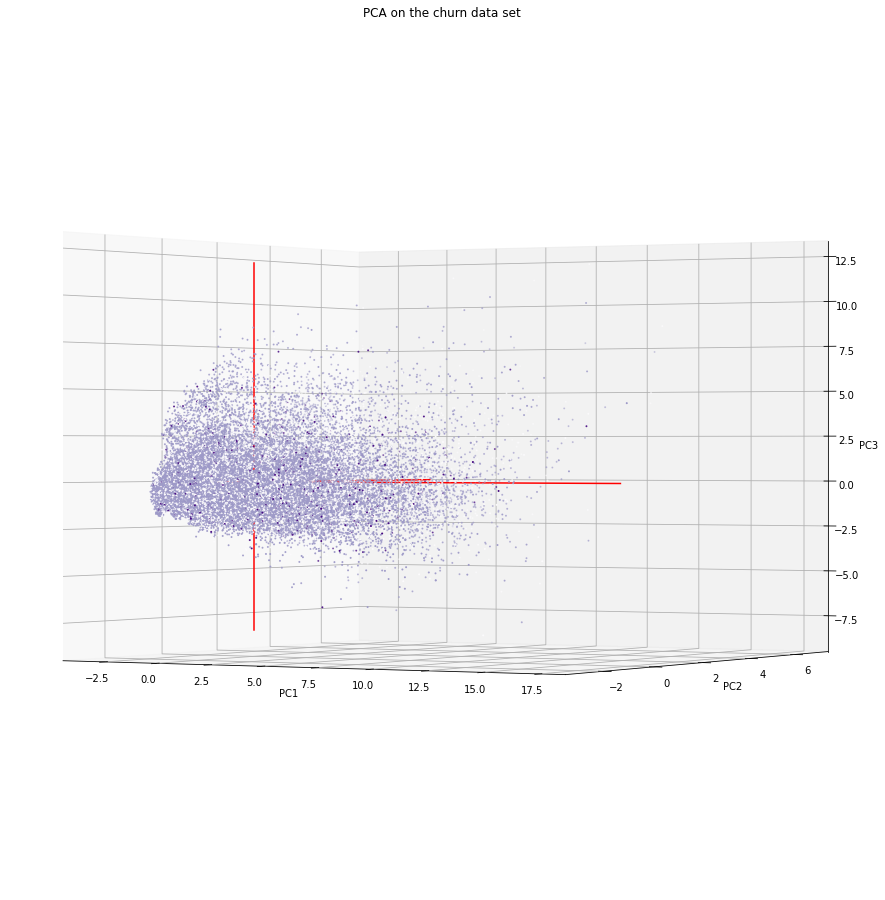

In [11]:
result['target'] = pd.Categorical(result['target'])
my_color=result['target'].cat.codes

fig = plt.figure(figsize=(30,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Purples", s=1)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the churn data set")
ax.view_init(0, 300)
plt.show()

In [12]:
# PCA 2D

X = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf.reset_index().drop(['index'], axis=1), y_train.reset_index().drop(['index'], axis=1)], axis = 1)

# fit knn and show insample performance 

model = KNeighborsClassifier(n_neighbors=4)
model.fit(principalDf,y_train)
predicted = model.predict_proba(principalDf)





In [13]:
finalDf["prediction"] = pd.DataFrame(predicted).iloc[:, 1]

finalDf.sort_values(by=["prediction"], inplace=True, ascending=False)

finalDf.head(250)["target"].sum(axis = 0) / 250 

# knn seems to work but oos performance questionable 




0.516

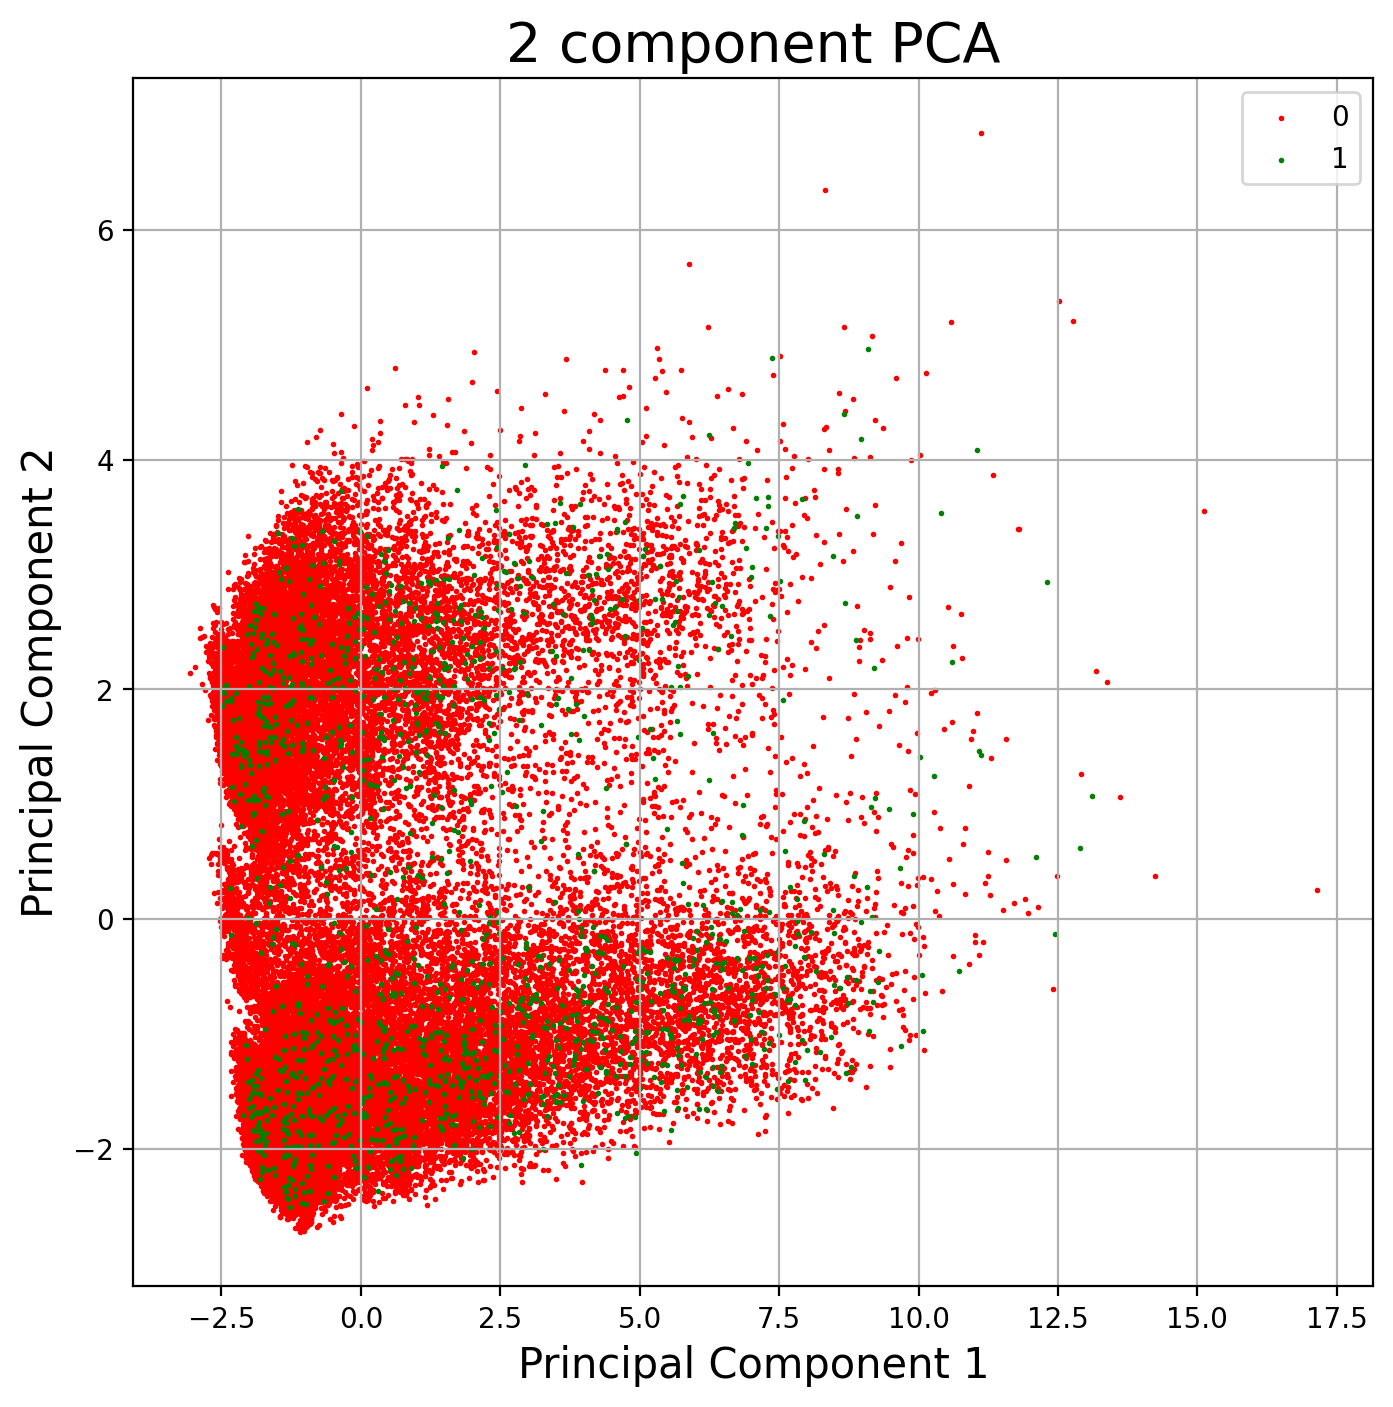

In [14]:
# plot the information 

fig = plt.figure(figsize = (8,8), dpi=200)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [ 0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

#### 6. New data 

In [15]:
# recreate all steps for the validation set 

# imputation of NAs
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_val)
X_val = imputer.transform(X_val)

# apply PCA transformation from training
newdata_transformed = pca.transform(X_val)

# remerge the target
principalDf_val = pd.DataFrame(data = newdata_transformed , columns = ['principal component 1', 'principal component 2'])
finalDf_val = pd.concat([principalDf_val.reset_index().drop(['index'], axis=1), y_val.reset_index().drop(['index'], axis=1)], axis = 1)

# predict with calculated model
predicted_val = model.predict_proba(principalDf_val)

finalDf_val["prediction"] = pd.DataFrame(predicted_val).iloc[:, 1]

finalDf_val.sort_values(by=["prediction"], inplace=True, ascending=False)

finalDf_val.head(250)["target"].sum(axis = 0) / 250 



0.04

In [16]:
finalDf_val.head(250)["target"].sum(axis = 0)

10

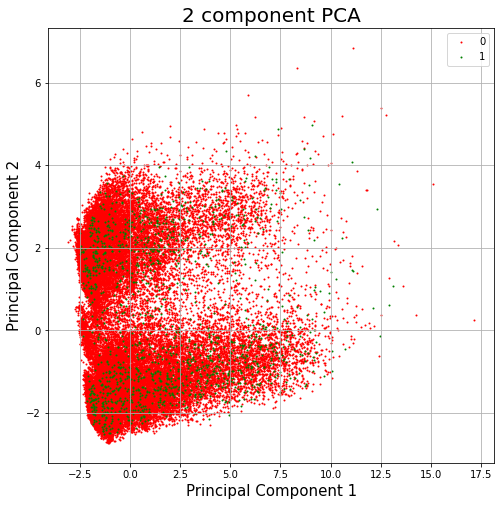

In [17]:
# plot the validation data 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [ 0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

#### Initial Pipeline 

In [18]:
np.random.seed(42)

#==========================================================================================================================================

# Load 

# test files
test_month_1 = pd.read_csv('data/test_month_1.csv')
test_month_2 = pd.read_csv('data/test_month_2.csv')
test_month_3 = pd.read_csv('data/test_month_3.csv')

# train files
train_month_1 = pd.read_csv('data/train_month_1.csv')
train_month_2 = pd.read_csv('data/train_month_2.csv')
train_month_3_with_target = pd.read_csv('data/train_month_3_with_target.csv')

#==========================================================================================================================================

# Data Cleaning 

# convert the dates into days before 2018 
train_month_3_with_target["customer_since_all"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_all"])).dt.days
train_month_3_with_target["customer_birth_date"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_birth_date"])).dt.days
train_month_3_with_target["customer_since_bank"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_bank"])).dt.days

# dummies for categorical variables
train_month_3_with_target = pd.DataFrame(pd.get_dummies(train_month_3_with_target, 
                                   columns = ["customer_education", "customer_occupation_code", "customer_children", "customer_relationship"], 
                                   dummy_na=True))

# drop unwanted columns (lateron distance from cities for postal codes)
train_month_3_with_target = train_month_3_with_target.drop(["customer_postal_code"], axis=1)
train_month_3_with_target = train_month_3_with_target.drop(["client_id"], axis=1)

# retain information of NAs in customer_since_all_na and customer_since_bank_na
train_month_3_with_target['customer_since_all_na'] = np.where(train_month_3_with_target.customer_since_all.notnull(), '0', '1')
train_month_3_with_target['customer_since_bank_na'] = np.where(train_month_3_with_target.customer_since_bank.notnull(), '0', '1')

#==========================================================================================================================================

# Train Test Split to prevent data pollution
y = train_month_3_with_target['target']
X = train_month_3_with_target.drop(['target'], axis = 1)
X_train, X_val, y_train, y_val = sk.train_test_split(X, y, test_size=0.3, stratify=y)
                                   
#==========================================================================================================================================

# print out missings first 
#print("#==============================")
#print("Missings in training Data ")
#print(pd.DataFrame(X_train).isna().sum(axis =0).sort_values(ascending=False).head(2))

#print("#==============================")
#print("Missings in validation Data ")
#print(pd.DataFrame(X_val).isna().sum(axis =0).sort_values(ascending=False).head(2))

# impute missings in the training and validation data seperately 
# or maybe together? 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)

imputer = imputer.fit(X_val)
X_val = imputer.transform(X_val)

#==========================================================================================================================================
# TRAINING:
# fit PCA on 2D

amount_NN = 200
amount_PC = 2

pca_cols = ["PCA_" + str(numeric_string) for numeric_string in list(range(amount_PC))]

X = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=amount_PC)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = pca_cols)
finalDf = pd.concat([principalDf.reset_index().drop(['index'], axis=1), y_train.reset_index().drop(['index'], axis=1)], axis = 1)

# fit knn and predicted values
# maybe two stage approach to evaluate vicinity to large clusters
model = KNeighborsClassifier(n_neighbors=amount_NN)
model.fit(principalDf,y_train)
predicted = model.predict_proba(principalDf)

# remerge to training data
finalDf["prediction"] = pd.DataFrame(predicted).iloc[:, 1]
finalDf.sort_values(by=["prediction"], inplace=True, ascending=False)

print("#==============================")
print("In sample hits of the top 250:")
print(str(finalDf.head(250)["target"].sum(axis = 0)), " - " ,str(finalDf.head(250)["target"].sum(axis = 0) / 250 ))

#==========================================================================================================================================
# Testing:

# apply PCA transformation from training
newdata_transformed = pca.transform(X_val)

# remerge the target
principalDf_val = pd.DataFrame(data = newdata_transformed , columns = pca_cols)
finalDf_val = pd.concat([principalDf_val.reset_index().drop(['index'], axis=1), y_val.reset_index().drop(['index'], axis=1)], axis = 1)

# predict with calculated model
predicted_val = model.predict_proba(principalDf_val)
finalDf_val["prediction"] = pd.DataFrame(predicted_val).iloc[:, 1]
finalDf_val.sort_values(by=["prediction"], inplace=True, ascending=False)

print("#==============================")
print("Out of Sample hits of the top 250:")
print(str(finalDf_val.head(250)["target"].sum(axis = 0)), " - " ,str(finalDf_val.head(250)["target"].sum(axis = 0) / 250 ))


#==============================
In sample hits of the top 250:
37  -  0.148
#==============================
Out of Sample hits of the top 250:
19  -  0.076


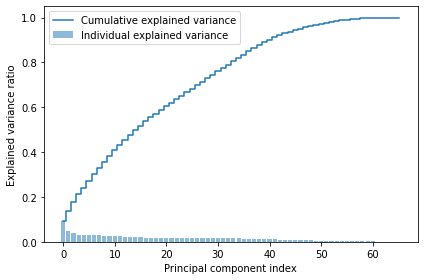

In [19]:
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Run Final Pipeline

In [20]:
# Start
#==========================================================================================================================================
%reset -f

# Packages
#==========================================================================================================================================

import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random as rd
import sklearn.model_selection as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

# Seed
#==========================================================================================================================================
np.random.seed(42)

# Load 
#==========================================================================================================================================

# test files
test_month_1 = pd.read_csv('data/test_month_1.csv')
test_month_2 = pd.read_csv('data/test_month_2.csv')
test_month_3 = pd.read_csv('data/test_month_3.csv')

# train files
train_month_1 = pd.read_csv('data/train_month_1.csv')
train_month_2 = pd.read_csv('data/train_month_2.csv')
train_month_3_with_target = pd.read_csv('data/train_month_3_with_target.csv')

# Data Cleaning 
#==========================================================================================================================================

# convert the dates into days before 2018 
train_month_3_with_target["customer_since_all"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_all"])).dt.days
train_month_3_with_target["customer_birth_date"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_birth_date"])).dt.days
train_month_3_with_target["customer_since_bank"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_bank"])).dt.days

# dummies for categorical variables
train_month_3_with_target = pd.DataFrame(pd.get_dummies(train_month_3_with_target, 
                                   columns = ["customer_education", "customer_occupation_code", "customer_children", "customer_relationship"], 
                                   dummy_na=True))

# drop unwanted columns
train_month_3_with_target = train_month_3_with_target.drop(["customer_postal_code"], axis=1)
train_month_3_with_target = train_month_3_with_target.drop(["client_id"], axis=1)

# retain information of NAs in customer_since_all_na and customer_since_bank_na
train_month_3_with_target['customer_since_all_na'] = np.where(train_month_3_with_target.customer_since_all.notnull(), '0', '1')
train_month_3_with_target['customer_since_bank_na'] = np.where(train_month_3_with_target.customer_since_bank.notnull(), '0', '1')

# Train Test Split
#==========================================================================================================================================

y = train_month_3_with_target['target']
X = train_month_3_with_target.drop(['target'], axis = 1)
X_train, X_val, y_train, y_val = sk.train_test_split(X, y, test_size=0.3, stratify=y)

# Imputation of slightly less relevant missings                                   
#==========================================================================================================================================

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)

imputer = imputer.fit(X_val)
X_val = imputer.transform(X_val)

# Training
#==========================================================================================================================================

# fit PCA on 2D

amount_NN = 1000
amount_PC = 3

pca_cols = ["PCA_" + str(numeric_string) for numeric_string in list(range(amount_PC))]

X = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=amount_PC)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = pca_cols)
finalDf = pd.concat([principalDf.reset_index().drop(['index'], axis=1), y_train.reset_index().drop(['index'], axis=1)], axis = 1)

# fit knn and predicted values
# maybe two stage approach to evaluate vicinity to large clusters
model = KNeighborsClassifier(n_neighbors=amount_NN)
model.fit(principalDf,y_train)
predicted = model.predict_proba(principalDf)

# remerge to training data
finalDf["prediction"] = pd.DataFrame(predicted).iloc[:, 1]
finalDf.sort_values(by=["prediction"], inplace=True, ascending=False)

print("#==============================")
print("In sample hits of the top 250:")
print(str(finalDf.head(250)["target"].sum(axis = 0)), " - " ,str(finalDf.head(250)["target"].sum(axis = 0) / 250 ))

# Validation
#==========================================================================================================================================


# apply PCA transformation from training
newdata_transformed = pca.transform(X_val)

# remerge the target
principalDf_val = pd.DataFrame(data = newdata_transformed , columns = pca_cols)
finalDf_val = pd.concat([principalDf_val.reset_index().drop(['index'], axis=1), y_val.reset_index().drop(['index'], axis=1)], axis = 1)

# predict with calculated model
predicted_val = model.predict_proba(principalDf_val)
finalDf_val["prediction"] = pd.DataFrame(predicted_val).iloc[:, 1]
finalDf_val.sort_values(by=["prediction"], inplace=True, ascending=False)

print("#==============================")
print("Out of sample hits of the top 250:")
print(str(finalDf_val.head(250)["target"].sum(axis = 0)), " - " ,str(finalDf_val.head(250)["target"].sum(axis = 0) / 250 ))


#==========================================================================================================================================
# Full Test set:

# Data Cleaning 

# convert the dates into days before 2018 
test_month_3["customer_since_all"] = (pd.to_datetime("2018-01") - pd.to_datetime(test_month_3["customer_since_all"])).dt.days
test_month_3["customer_birth_date"] = (pd.to_datetime("2018-01") - pd.to_datetime(test_month_3["customer_birth_date"])).dt.days
test_month_3["customer_since_bank"] = (pd.to_datetime("2018-01") - pd.to_datetime(test_month_3["customer_since_bank"])).dt.days

# dummies for categorical variables
test_month_3 = pd.DataFrame(pd.get_dummies(test_month_3, 
                                   columns = ["customer_education", "customer_occupation_code", "customer_children", "customer_relationship"], 
                                   dummy_na=True))

# drop unwanted columns (lateron distance from cities for postal codes)
stepn = test_month_3.drop(["customer_postal_code"], axis=1)
stepn = stepn.drop(["client_id"], axis=1)

# retain information of NAs in customer_since_all_na and customer_since_bank_na
stepn['customer_since_all_na'] = np.where(stepn.customer_since_all.notnull(), '0', '1')
stepn['customer_since_bank_na'] = np.where(stepn.customer_since_bank.notnull(), '0', '1')

#==========================================================================================================================================

imputer = imputer.fit(stepn)
stepn = imputer.transform(stepn)

# apply PCA transformation from training
newdata_transformed = pca.transform(stepn)

# remerge the colnames
testdata = pd.DataFrame(data = newdata_transformed , columns = pca_cols)

# predict with calculated model
predicted_val = pd.DataFrame(model.predict_proba(testdata))

test_month_3["PROB"] = predicted_val[1]

final = test_month_3[["client_id", "PROB"]]





#==============================
In sample hits of the top 250:
31  -  0.124
#==============================
Out of sample hits of the top 250:
29  -  0.116
